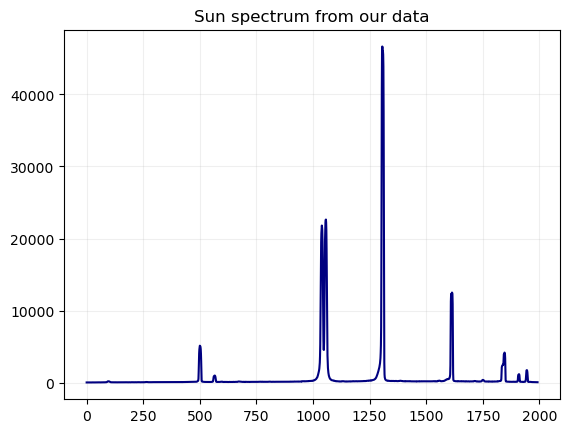

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imageio import imwrite, imread
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c, e
import sympy as sp
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm, MinMaxInterval

sun_data = np.loadtxt("Lena_calibration.txt", comments="#")

fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(sun_data, color="navy", label="Vega spectrum")
frame.set_title("Sun spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

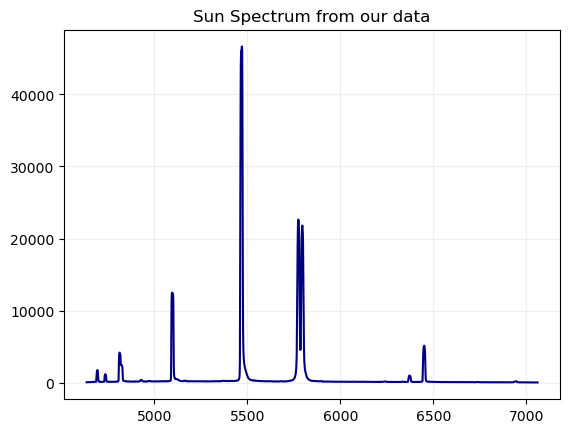

In [40]:
x_range = np.arange(0, np.size(sun_data))
x_range_a = x_range*-1.217+7060

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(x_range_a,sun_data,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Sun Spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

[array([12000,  5100,     5]), array([50000,  5500,     5]), array([8000, 6450,    5])]
Parameters: [ 1.38588842e+04  5.09714748e+03  4.44845034e+00  5.19055379e+04
  5.46850808e+03 -4.79818739e+00  5.24062337e+03  6.45037703e+03
  4.35796038e+00  4.37700073e+02]
Gaussian parameters: [[ 1.38588842e+04  5.09714748e+03  4.44845034e+00]
 [ 5.19055379e+04  5.46850808e+03 -4.79818739e+00]
 [ 5.24062337e+03  6.45037703e+03  4.35796038e+00]]


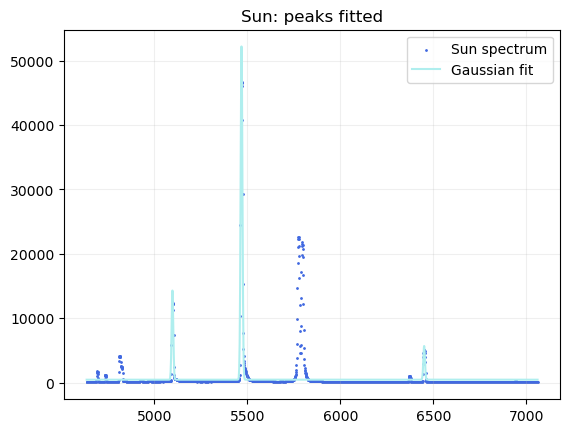

In [41]:
def f_superior(x, *params):
    """Returns a combination of multiple Gaussians plotted on a straight line"""
    num_gaussians = (len(params)-1) // 3
    y = np.zeros_like(x, dtype=float) #it was having some weird type issues
    for i in range(num_gaussians):
        a = params[3 * i]
        m = params[3 * i + 1]
        s = params[3 * i + 2]
        y += a * np.exp(-(x - m) ** 2 / (2.0 * s ** 2))
    z = params[-1:]
    y+=z
    return y

D1=np.array([12000,5100,5])
D2=np.array([50000,5500,5]) #Na I
D3 = np.array([8000,6450,5]) #?


# arcturus_miles_line=alsbaseline(arcturus_miles_line, remove=False, lam=1)

initial_gaussians = [D1, D2, D3]
print(initial_gaussians)
initial_guess = [item for sublist in initial_gaussians for item in sublist] + [0]

beta, pcov = curve_fit(f_superior, x_range_a, sun_data, p0=initial_guess)
print("Parameters:", beta) #it's not printing the figure if i remove this line, no idea why

# extracting the fitted parameters
num_gaussians = len(initial_gaussians)
gaussian_params = beta[:num_gaussians * 3].reshape((num_gaussians, 3))
z = beta[-1]

# poor attempt at error analysis
# gaussian_params_err = pcov[:num_gaussians * 3].reshape((num_gaussians, 3))
# exp_params_err = pcov[num_gaussians * 3:]
err=np.sqrt(np.diag(pcov))
fwhm_err=2*err[2]*np.sqrt(2*np.log(2))

print("Gaussian parameters:", gaussian_params)


# plotting the final fit
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.scatter(x_range_a, sun_data, color="royalblue", label="Sun spectrum", s=1)
frame.plot(x_range_a, f_superior(x_range_a, *beta), color="paleturquoise", label="Gaussian fit")
frame.set_title("Sun: peaks fitted")
frame.grid(alpha=0.2)
frame.legend()
show()
close(fig)

[10.47530004 11.29886783 10.26221245]
Cd peak equivalent width: 10.475300040414028
Hg peak equivalent width: 11.298867834028428
Cd peak equivalent width: 10.262212449561853
Error in FWHMs: 0.9042025388599133


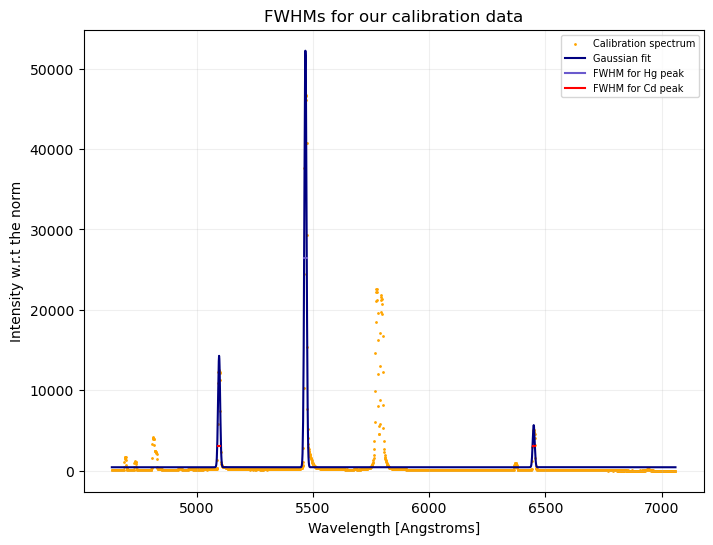

In [42]:
FWHM = np.array([2*np.abs(Peak[2])*np.sqrt(2*np.log(2)) for Peak in gaussian_params])
print(FWHM)

c=0
PeakDescriptions=["Cd", "Hg","Cd"]
PeakColors=["red","slateblue","red"]
for Peak in gaussian_params:
    print(f"{PeakDescriptions[c]} peak equivalent width: {FWHM[c]}")
    c+=1

print(f"Error in FWHMs: {fwhm_err}")

# 1.2056420239473526 4615.032805371546

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(x_range_a,sun_data, color="orange", label="Calibration spectrum",s=1)
frame.plot(x_range_a,f_superior(x_range_a, *beta),color="navy", label="Gaussian fit")

p=0

PeakPositions = []
for Peak in gaussian_params:
    a,m,s=Peak
    PeakPositions.append(m)
    f=FWHM[p]
    fwhm_x=np.array((m-f/2,m+f/2))

    # getting the exponential fit data to know the y-coordinates of FWHM plot
    if (p==0):
        frame.plot(fwhm_x,fwhm_y,color=PeakColors[p])
        p+=1
        continue

    fwhm_y=np.array((a/2+z,a/2+z))

    frame.plot(fwhm_x,fwhm_y,color=PeakColors[p], label=f"FWHM for {PeakDescriptions[p]} peak")
    p+=1

frame.set_title("FWHMs for our calibration data")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=7)
show()
close(fig)